In [49]:
# 21 cm map generator
# We want to create 3D snapshot of stars + Dust to have the UV emission, which could affect the spin temperature of HI

In [50]:
import sys
sys.path.insert(0, '/export/home/extragal/lucia.armillotta/pyathena')
import pyathena as pa

from astropy import units
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import h5py
from matplotlib.colors import LogNorm

basedir = '/export/home/extragal/lucia.armillotta/TIGRESS/R8'
output_dir = '/export/home/extragal/francesco.chititegli/TIGRESS_1/H21maps/'
snapshot_number = 0

s = pa.LoadSim(basedir, verbose=False)
ds = s.load_vtk(num=s.nums[snapshot_number])
u = s.u

[FindFiles-WARNING] Vtk file size is not unique.
[FindFiles-WARNING] vtk num: 0, size [MB]: 8834
[FindFiles-WARNING] vtk num: 1, size [MB]: 8834
[FindFiles-WARNING] vtk num: 2, size [MB]: 8834
[FindFiles-WARNING] vtk num: 3, size [MB]: 8834
[FindFiles-WARNING] vtk num: 4, size [MB]: 8834
[FindFiles-WARNING] vtk num: 5, size [MB]: 8834
[FindFiles-WARNING] vtk num: 6, size [MB]: 8834
[FindFiles-WARNING] vtk num: 7, size [MB]: 8834
[FindFiles-WARNING] vtk num: 8, size [MB]: 8834
[FindFiles-WARNING] rst files in out_fmt but not found.
/export/home/extragal/lucia.armillotta/.conda/envs/pyathena/lib/python3.11/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


In [3]:
# Lenghts are already in pc, Velocities are already in km/s, Temperatures seem to already be in K
time_cf = (u.time).to(units.Gyr).value
mass_cf = (s.u.mass).to(units.M_sun).value
density_cf = (s.u.density).to(units.M_sun / units.pc**3).value
number_density_cf = (units.cm**-3).to(units.pc**-3)
solar_metallicity = 0.0134
dust_to_gas_ratio = 0.01
h_alpha_wave = 0.65628 # (micron)
h_alpha_energy = 3.03e-12 # (erg)
H_mass = 8.41e-58 # (Msun)
H_mass_grams = 1.67e-24 # (grams)

print(s.basedir)
print(s.basename)
print(s.problem_id)
Nx = ds.domain['Nx']

dx = ds.domain['dx']
volume = dx[0] * dx[1] * dx[2]
s.domain

/export/home/extragal/lucia.armillotta/TIGRESS/R8
R8
R8_4pc_NCR


{'all_grid_equal': True,
 'ngrid': 768,
 'le': array([ -512.,  -512., -3072.], dtype=float32),
 're': array([ 512.,  512., 3072.], dtype=float32),
 'dx': array([4., 4., 4.], dtype=float32),
 'Lx': array([1024., 1024., 6144.], dtype=float32),
 'center': array([0., 0., 0.], dtype=float32),
 'Nx': array([ 256,  256, 1536]),
 'ndim': 3,
 'time': 200.0007}

In [4]:
# Dust
# Cells borders (pc)
xmin = ds.domain['le'][0] + dx[0] * np.arange(Nx[0])
ymin = ds.domain['le'][1] + dx[1] * np.arange(Nx[1])
zmin = ds.domain['le'][2] + dx[2] * np.arange(Nx[2])
xmax = xmin + dx[0]
ymax = ymin + dx[1]
zmax = zmin + dx[2]

# Cells velocities (km/s)
velocities_x = ds.get_field('vx')
velocities_y = ds.get_field('vy')
velocities_z = ds.get_field('vz')

electron_density = ds.get_field('ne')  # Electrons Densities DERIVED FIELDS (1/cm3) -> (1/pc3) number_density_cf
temperature = ds.get_field('T')  # Temperatures (K)
gas_density = ds.get_field('rho')  # Gas density (g/cm3) -> (Msun/pc3) density_cf
HI_num_density = ds.get_field('nHI') # Neutral Hydrogen NUMBER density (1/cm3) -> (1/pc3) number_density_cf
H2_num_density = ds.get_field('nH2') # Molecular Hydrogen NUMBER density (1/cm3) -> (1/pc3) number_density_cf

In [5]:
# Stars
sp = s.load_starpar_vtk(num=s.nums_starpar[snapshot_number])

positions_stars_unmasked = np.array(sp[['x1', 'x2', 'x3']]) # Postions (pc)
velocities_stars_unmasked = np.array(sp[['v1', 'v2', 'v3']])  # Velocities (km/s)
mass_stars_unmasked = np.array(sp['mass'])  # Mass (Msun) -> (Msun) mass_cf
age_stars_unmasked = np.array(sp['age']) # Age (s) -> (Gyr) time_cf
smoothing_length_stars_unmasked = np.full_like(mass_stars_unmasked, 4.) # Smoothing Lenght (4 pc)
metallicities_umasked = np.full_like(mass_stars_unmasked, solar_metallicity) # Metallicity (Zsun)

print('Min non-zero age: ' + str(np.min(age_stars_unmasked[age_stars_unmasked > 0])))
print('Min non-zero mass: ' + str(np.min(mass_stars_unmasked[mass_stars_unmasked > 0])))

# Some of them have negative age, or null mass, so we mask them out
stars_mask = (mass_stars_unmasked > 0) & (age_stars_unmasked > 0)
positions_stars = positions_stars_unmasked[stars_mask]
velocities_stars = velocities_stars_unmasked[stars_mask]
mass_stars = mass_stars_unmasked[stars_mask]
age_stars = age_stars_unmasked[stars_mask]
smoothing_length_stars = smoothing_length_stars_unmasked[stars_mask]
metallicities = metallicities_umasked[stars_mask]

print('Pre-mask shape: ' + str(positions_stars.shape) + ' VS Post-mask shape: ' + str(positions_stars.shape))
print('Post-mask mass range [Msun]: ' + str(mass_stars.min() * mass_cf) + ' to ' + str(mass_stars.max() * mass_cf))
print('Post-mask age range [Gyr]: ' + str(age_stars.min() * time_cf) + ' to ' + str(age_stars.max() * time_cf))
print('Post-mask metal range [1]: ' + str(metallicities.min()) + ' to ' + str(metallicities.max()))

Min non-zero age: 0.4214305579662323
Min non-zero mass: 5463.05859375
Pre-mask shape: (122, 3) VS Post-mask shape: (122, 3)
Post-mask mass range [Msun]: 189.15561998383632 to 155988.6788593846
Post-mask age range [Gyr]: 0.00041207152155797695 to 0.2343650207318719
Post-mask metal range [1]: 0.0134 to 0.0134


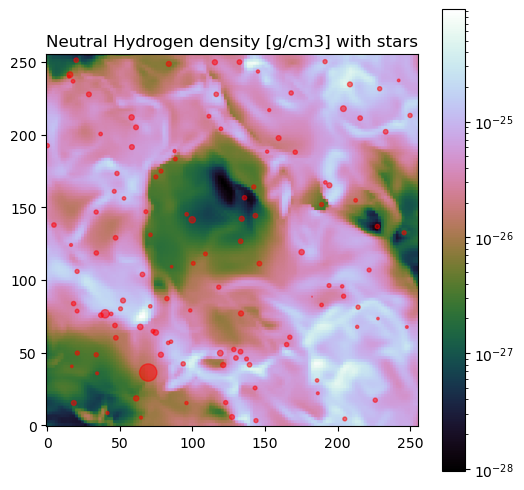

In [6]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_data = np.mean((HI_num_density['nHI'].data).transpose(2, 1, 0), axis=-1).transpose() * H_mass_grams
plt.scatter(np.array(positions_stars)[:, 0]/4. + 128., np.array(positions_stars)[:, 1]/4. + 128., s=mass_stars * 1e-3 * mass_cf, c='red', alpha=0.5)
im = ax.imshow(plot_data, cmap='cubehelix', origin='lower', norm=LogNorm(vmin=plot_data.min(), vmax=plot_data.max()))
plt.colorbar(im, ax=ax)
ax.set_title('Neutral Hydrogen density [g/cm3] with stars')
plt.show()

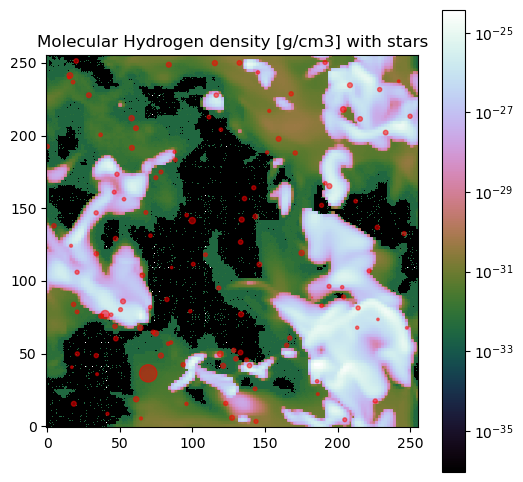

In [7]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_data = np.mean((H2_num_density['nH2'].data).transpose(2, 1, 0), axis=-1).transpose() * H_mass_grams * 2
plt.scatter(np.array(positions_stars)[:, 0]/4. + 128., np.array(positions_stars)[:, 1]/4. + 128., s=mass_stars * 1e-3 * mass_cf, c='red', alpha=0.5)
im = ax.imshow(plot_data, cmap='cubehelix', origin='lower', norm=LogNorm(vmin=plot_data.min(), vmax=plot_data.max()))
plt.colorbar(im, ax=ax)
ax.set_title('Molecular Hydrogen density [g/cm3] with stars')
plt.show()

In [8]:
# RIDOTTO: we only take a thin slice of 256 pc

In [9]:
# (-256 < x3 < 256 /// 704 < Nx[3] < 832) YES

In [14]:
# Dust array 3D data & Hydrogen array
dust_array = []
hydrogen_array =  []
HI_emission_array = []
ID_number = 0

for i in range(Nx[0]):
    print(i)
    for j in range(Nx[1]):
        for k in range(704, 832):
            xmin_val = xmin[i]
            ymin_val = ymin[j]
            zmin_val = zmin[k]
            xmax_val = xmax[i]
            ymax_val = ymax[j]
            zmax_val = zmax[k]
            
            dust_density_val = (gas_density['rho'].data)[k, j, i] * dust_to_gas_ratio
            temperature_val = (temperature['T'].data)[k, j, i]
            HI_ndens_val = (HI_num_density['nHI'].data)[k, j, i]
            H2_ndens_val = (H2_num_density['nH2'].data)[k, j, i]
            metallicities_val = solar_metallicity * 0.03

            hydrogen_density_val = (HI_ndens_val + H2_ndens_val * 2) * H_mass_grams
            H_surf_val = hydrogen_density_val * (units.g).to(units.M_sun) * number_density_cf * 4.0

            HI_prefattore = (3/4) * 2.8843e-15 * 6.62e-27 * 3.0e8 / 21e-2
            HI_lum_val = HI_prefattore * HI_ndens_val * number_density_cf * volume
 
            dust_array.append([xmin_val, ymin_val, zmin_val, xmax_val, ymax_val, zmax_val, dust_density_val, temperature_val])
            hydrogen_array.append([xmin_val, ymin_val, zmin_val, xmax_val, ymax_val, zmax_val, hydrogen_density_val, metallicities_val, temperature_val, H_surf_val])
            HI_emission_array.append([HI_lum_val])

            ID_number = ID_number + 1

dust_array = np.array(dust_array)
hydrogen_array = np.array(hydrogen_array)
HI_emission_array = np.array(HI_emission_array)

print("Final ID_Number: " + str(ID_number))
del ID_number

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
Final ID_Number: 8388608


In [12]:
print('Default metallicity of the gas: ' + str(np.mean(hydrogen_array[:,7])))
print('Average temperature of the gas: ' + str(np.mean(hydrogen_array[:,8])) + ' K')
print('Average Sur Mass Dens of the gas: ' + str(np.mean(hydrogen_array[:,9])) + ' Msun/pc3')

Default metallicity of the gas: 0.00040200000000000923
Average temperature of the gas: 499558.7957791797 K
Average Sur Mass Dens of the gas: 0.03778798816797816 Msun/pc3


In [41]:
prefattore = 1e23 * 1e8 * 1e-6 / (4*np.pi* (3.086e25)**2) # (erg/s) -> (MJy/sr)
print(prefattore)

8.355997329728561e-28


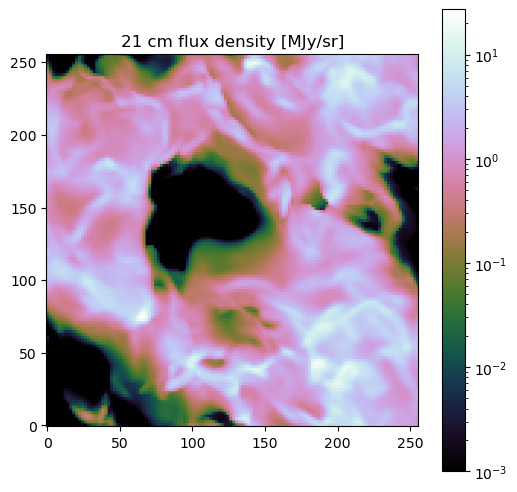

Dynamical range -10.897772517950582 to 1.4382487968762379
Integrated: 97637.2546248015 MJy/sr


In [48]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_data = np.sum(HI_emission_array.reshape(256, 256, 128), axis=-1).transpose()
plot_data = plot_data * prefattore
im = ax.imshow(plot_data, cmap='cubehelix', origin='lower', norm=LogNorm(vmin=1e-3, vmax=plot_data.max()))
plt.colorbar(im, ax=ax)
ax.set_title('21 cm flux density [MJy/sr]')
plt.show()
print('Dynamical range ' + str(np.log10(plot_data.min())) + ' to ' + str(np.log10(plot_data.max())) )
print('Integrated: ' + str(np.sum(plot_data)) + ' MJy/sr')

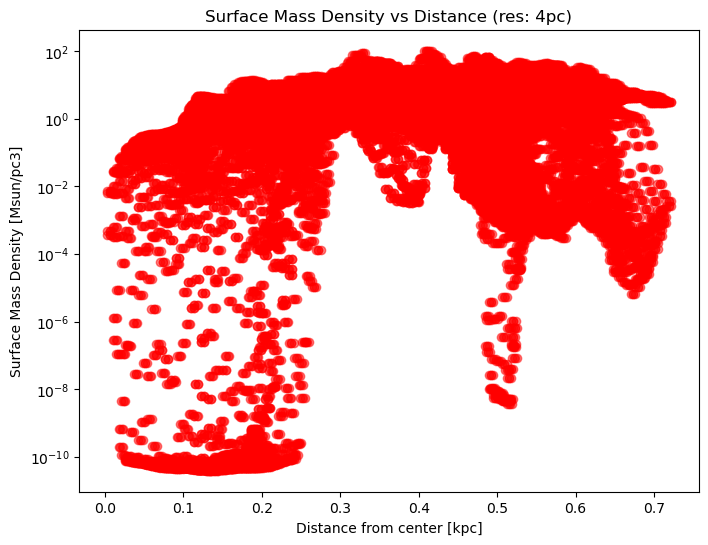

In [38]:

gal_distance = 1e-3 * np.sqrt( ((hydrogen_array[:,0] + hydrogen_array[:,3]) / 2)**2 + ((hydrogen_array[:,1] + hydrogen_array[:,4]) / 2)**2 )
gal_distance = gal_distance.reshape(256, 256, 128)[...,0].transpose()
gas_surf = np.sum(hydrogen_array[:,9].reshape(256, 256, 128), axis=-1).transpose()

plt.figure(figsize=(8, 6))
plt.scatter(gal_distance, gas_surf, c='red', alpha=0.5)
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Distance from center [kpc]')
plt.ylabel('Surface Mass Density [Msun/pc3]')
plt.title('Surface Mass Density vs Distance (res: 4pc)')
plt.show()

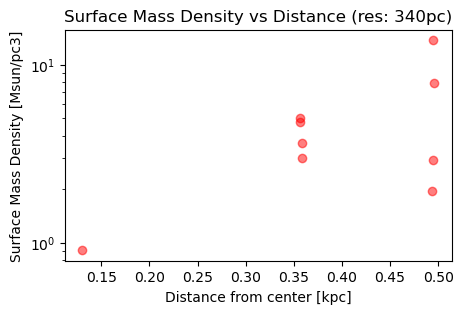

In [39]:
def process_arrays(distan, densit, macro_size=(85, 85, 86)):
    result_dist = np.zeros((3, 3))
    result_dens = np.zeros((3, 3))
    
    for i in range(3):
        for j in range(3):
            row_start = i * macro_size[i] if i < 2 else (i * macro_size[i])
            row_end = (i + 1) * macro_size[i] if i < 2 else 256
            col_start = j * macro_size[j] if j < 2 else (j * macro_size[j])
            col_end = (j + 1) * macro_size[j] if j < 2 else 256

            result_dist[i, j] = np.mean(distan[row_start:row_end, col_start:col_end])
            result_dens[i, j] = np.mean(densit[row_start:row_end, col_start:col_end])
    
    return result_dist, result_dens

plt.figure(figsize=(5, 3))
plt.scatter(process_arrays(gal_distance, gas_surf)[0], process_arrays(gal_distance, gas_surf)[1], c='red', alpha=0.5)
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Distance from center [kpc]')
plt.ylabel('Surface Mass Density [Msun/pc3]')
plt.title('Surface Mass Density vs Distance (res: 340pc)')
plt.show()

In [90]:
counter = 0
for i in np.arange(positions_stars.shape[0]):
        if (704 * 4 - 3072 <= positions_stars[i,2]):
            if (positions_stars[i,2] < 832 * 4 - 3072):
                counter = counter + 1
print(str(counter) + ' stars in the area VS total of ' + str(positions_stars.shape[0]))

stars_array = []
for i in np.arange(positions_stars.shape[0]):
    if (704 * 4 - 3072 <= positions_stars[i,2]):
        if (positions_stars[i,2] < 832 * 4 - 3072):
            position_x = positions_stars[i,0]
            position_y = positions_stars[i,1]
            position_z = positions_stars[i,2]
            smoothing_length = smoothing_length_stars[i]
            
            #velocity_x = velocities_stars[i,0]
            #velocity_y = velocities_stars[i,1]
            #velocity_z = velocities_stars[i,2]
            
            mass = mass_stars[i] * mass_cf # SKIRT wants the initial mass, not the current mass
            metal = metallicities[i]
            age = age_stars[i] * time_cf

            stars_array.append([position_x, position_y, position_z, smoothing_length, mass, metal, age])
stars_array = np.array(stars_array)
print(stars_array.shape)

121 stars in the area VS total of 122
(121, 7)


In [103]:
header = """# Dust_21_Ridotto.txt: import file for cell media -- dust
# Column 1: xmin (pc)
# Column 2: ymin (pc)
# Column 3: zmin (pc)
# Column 4: xmax (pc)
# Column 5: ymax (pc)
# Column 6: zmax (pc)
# Column 7: mass density (g/cm3)
# Column 8: temperature (K)
#
"""

with open(f"{output_dir}Dust_21_Ridotto.txt", "w") as txt_file:
    txt_file.write(header)
    np.savetxt(txt_file, dust_array, fmt="%g")

header = """# Hydrogen_21_Ridotto.txt: import file for cell media -- gas
# Column 1: xmin (pc)
# Column 2: ymin (pc)
# Column 3: zmin (pc)
# Column 4: xmax (pc)
# Column 5: ymax (pc)
# Column 6: zmax (pc)
# Column 7: mass density (g/cm3)
# Column 8: metallicity (1)
# Column 9: temperature (K)
# Column 10: surface mass density (Msun/pc2)
#
"""

with open(f"{output_dir}Hydrogen_21_Ridotto.txt", "w") as txt_file:
    txt_file.write(header)
    np.savetxt(txt_file, hydrogen_array, fmt="%g")

header = """# Stars_21_Ridotto.txt: import file for particle source 
# Column 1: position x (pc)
# Column 2: position y (pc)
# Column 3: position z (pc)
# Column 4: smoothing length (pc)
# Column 5: mass (Msun)
# Column 6: metallicity (1)
# Column 7: age (Gyr)
#
"""

with open(f"{output_dir}Stars_21_Ridotto.txt", "w") as txt_file:
    txt_file.write(header)
    np.savetxt(txt_file, stars_array, fmt="%g")

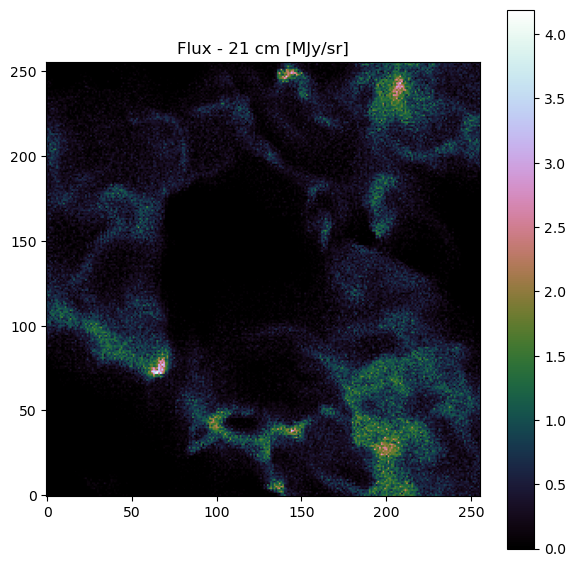

BUNIT: MJy/sr
Dynamic Range: 0.0 to 4.1908264
Integrated flux: 19902.463 Jy


In [47]:
from astropy.io import fits
pixel_MJysr_to_Jy = 1.6e-7
with fits.open(f"{output_dir}HITr2_i0_total.fits") as hdul:
    image_fits = hdul[0].data
    header = hdul[0].header

fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(np.squeeze(image_fits[51]), cmap='cubehelix', origin='lower')
#plt.scatter(np.array(positions_stars)[:, 0]/4. + 128., np.array(positions_stars)[:, 1]/4. + 128., s=mass_stars * 1e-3 * mass_cf, c='red', alpha=0.5)
plt.colorbar(im, ax=ax)
ax.set_title('Flux - 21 cm [MJy/sr]')
#plt.xlim(50,100)
#plt.ylim(25,75)
#plt.grid()
plt.show()

print(f"BUNIT: {header['BUNIT']}")
print('Dynamic Range: ' + str(image_fits[51].min()) + ' to ' + str(image_fits[51].max()))
print('Integrated flux: ' + str(np.sum(image_fits[51])) + ' Jy')

In [13]:
image_fits_nodust[34].shape

(256, 256)

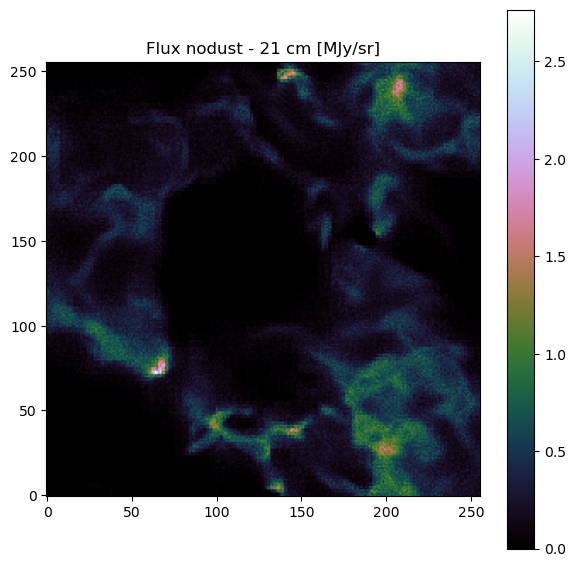

BUNIT: MJy/sr
Dynamic Range: 0.0 to 2.7642915
Integrated flux: 13120.69 Jy


In [46]:
with fits.open(f"{output_dir}HITr_i0_total.fits") as hdul:
    image_fits_nodust = hdul[0].data
    header_nodust = hdul[0].header

fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(np.squeeze(image_fits_nodust[34]), cmap='cubehelix', origin='lower')
#plt.scatter(np.array(positions_stars)[:, 0]/4. + 128., np.array(positions_stars)[:, 1]/4. + 128., s=mass_stars * 1e-3 * mass_cf, c='red', alpha=0.5)
plt.colorbar(im, ax=ax)
ax.set_title('Flux nodust - 21 cm [MJy/sr]')
#plt.xlim(50,100)
#plt.ylim(25,75)
#plt.grid()
plt.show()

print(f"BUNIT: {header['BUNIT']}")
print('Dynamic Range: ' + str(image_fits_nodust[34].min()) + ' to ' + str(image_fits_nodust[34].max()))
print('Integrated flux: ' + str(np.sum(image_fits_nodust[34])) + ' Jy')

In [9]:
min_dust = np.min(image_fits[51][image_fits[51] > 0])
min_nodust = np.min(image_fits_nodust[34][image_fits_nodust[34] > 0])
print('Minimum dust: ' + str(min_dust) + ' e minimum nodust: ' + str(min_nodust))
print('Zero goes to : ' + str(1e-15))

Minimum dust: 2.4468627e-18 e minimum nodust: 7.283935e-20
Zero goes to : 1e-15


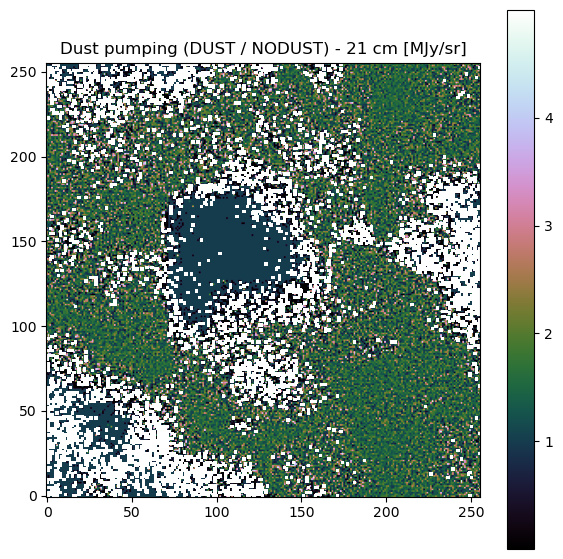

Dynamic Range: 9.725062e-10 to 4.999939


In [11]:
# Dust pumping
ratio = np.where(image_fits[51] == 0, 1e-15, image_fits[51]) / np.where(image_fits_nodust[34] == 0, 1e-15, image_fits_nodust[34])
ratio_masked = np.ma.masked_where(ratio >= 5, ratio)

fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(ratio_masked, cmap='cubehelix', origin='lower')
#plt.scatter(np.array(positions_stars)[:, 0]/4. + 128., np.array(positions_stars)[:, 1]/4. + 128., s=mass_stars * 1e-3 * mass_cf, c='red', alpha=0.5)
plt.colorbar(im, ax=ax)
ax.set_title('Dust pumping (DUST / NODUST) - 21 cm [MJy/sr]')
#plt.xlim(50,100)
#plt.ylim(25,75)
#plt.grid()
plt.show()

print('Dynamic Range: ' + str(ratio_masked.min()) + ' to ' + str(ratio_masked.max()))

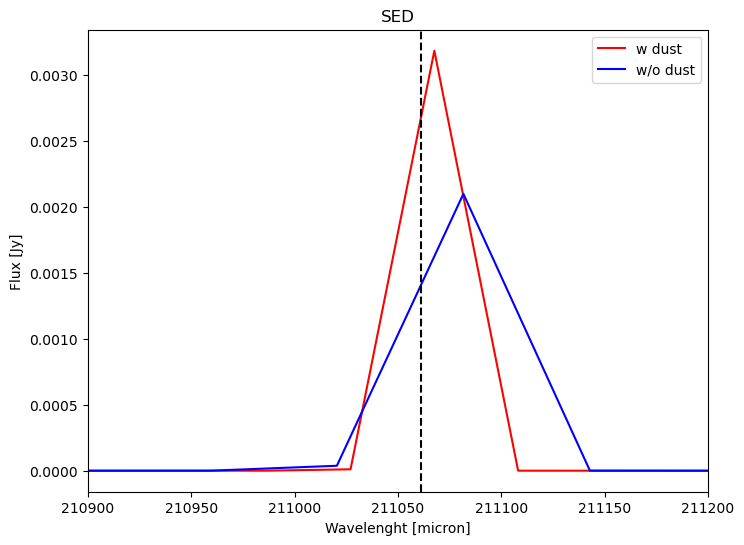

Maximum peak at the slice number 51
Maximum peak (NO DUST) at the slice number 34


In [35]:
plot_sed = np.loadtxt(f"{output_dir}HITr2_i0_sed.dat")
plot_sed_nodust = np.loadtxt(f"{output_dir}HITr_i0_sed.dat")

plt.figure(figsize=(8, 6))
plt.plot(plot_sed[:,0], plot_sed[:,1], color="red", linewidth=1.5, label='w dust')
plt.plot(plot_sed_nodust[:,0], plot_sed_nodust[:,1], color="blue", linewidth=1.5, label='w/o dust')
plt.xlabel("Wavelenght [micron]")
plt.ylabel("Flux [Jy]")
plt.title("SED")
plt.legend()
plt.xlim(210900,211200)
plt.axvline(x=211061, color='k', linestyle='--', label='HI rest')
plt.show()

print('Maximum peak at the slice number ' + str(np.argmax(plot_sed[:,1])))
print('Maximum peak (NO DUST) at the slice number ' + str(np.argmax(plot_sed_nodust[:,1])))

In [37]:
sampled_densities.max()

2.3072051117122175e-23

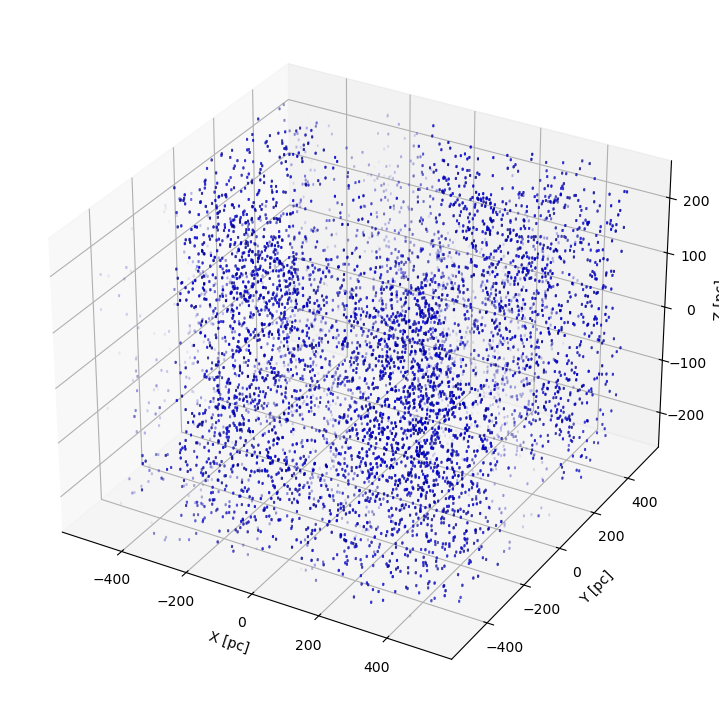

In [51]:
# 3D plot of the HI distribution
from mpl_toolkits.mplot3d import Axes3D

cells = hydrogen_array[:, :6]
hydrogen_dents = hydrogen_array[:, 6]

sampled_cells_idx = np.random.choice(hydrogen_array.shape[0], size=int(0.001 * hydrogen_array.shape[0]), replace=False)
sampled_cells = cells[sampled_cells_idx]
sampled_densities = hydrogen_dents[sampled_cells_idx]

offset_density = np.maximum(sampled_densities, 1e-28)
log_densities = np.log10(offset_density)
log_densities = np.nan_to_num(log_densities, nan=0.0, posinf=0.0, neginf=0.0)
log_densities_normalized = (log_densities - log_densities.min()) / (log_densities.max() - log_densities.min())

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')

for i, cell in enumerate(sampled_cells):
    xmin, ymin, zmin, xmax, ymax, zmax = cell
    density = log_densities_normalized[i]
    
    alpha = density

    ax.bar3d(xmin, ymin, zmin, xmax-xmin, ymax-ymin, zmax-zmin, color='b', alpha=alpha)

ax.set_xlabel('X [pc]')
ax.set_ylabel('Y [pc]')
ax.set_zlabel('Z [pc]')
plt.subplots_adjust()
plt.show()